Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000


/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


Class 0 : intra connection probability 0.6994106090373281
Class 1 : intra connection probability 0.7949465500485908
Class 2 : intra connection probability 0.9058050383351588
Class 3 : intra connection probability 0.8280479210711769
Class 4 : intra connection probability 0.8291457286432161
Class 5 : intra connection probability 0.7679558011049724
Class 6 : intra connection probability 0.7689969604863222
average loss for epoch 0 is 0.3406258821487427, with avg accu 0.6353602175701673, forward time 1.9669075012207031, backward time 1.0440504550933838
average loss for epoch 1 is 0.3324926793575287, with avg accu 0.6356046041240424, forward time 1.973668098449707, backward time 1.0809557437896729
average loss for epoch 2 is 0.3245263695716858, with avg accu 0.6368987143446438, forward time 1.981353998184204, backward time 1.0423030853271484
total time 9.08923888206482 s, average 4.54461944103241


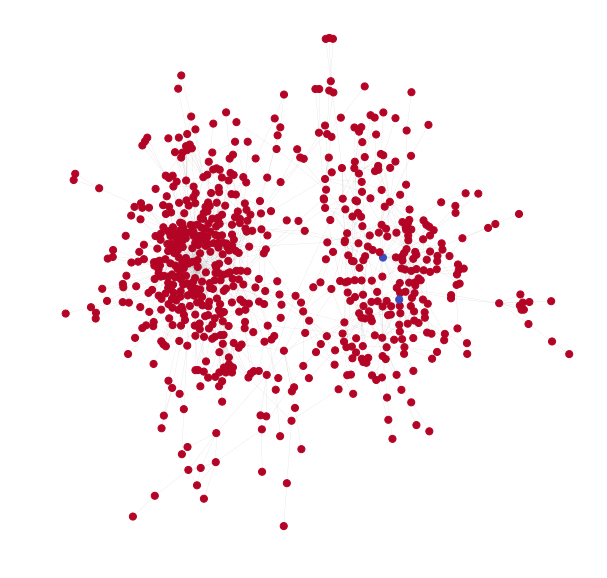

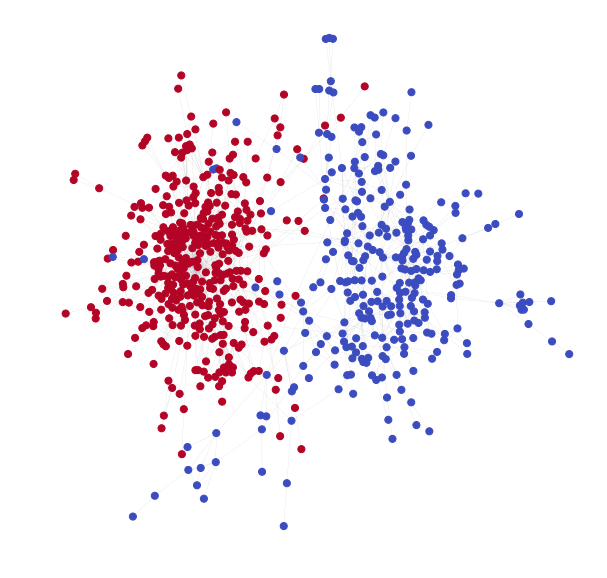

<IPython.core.display.Javascript object>


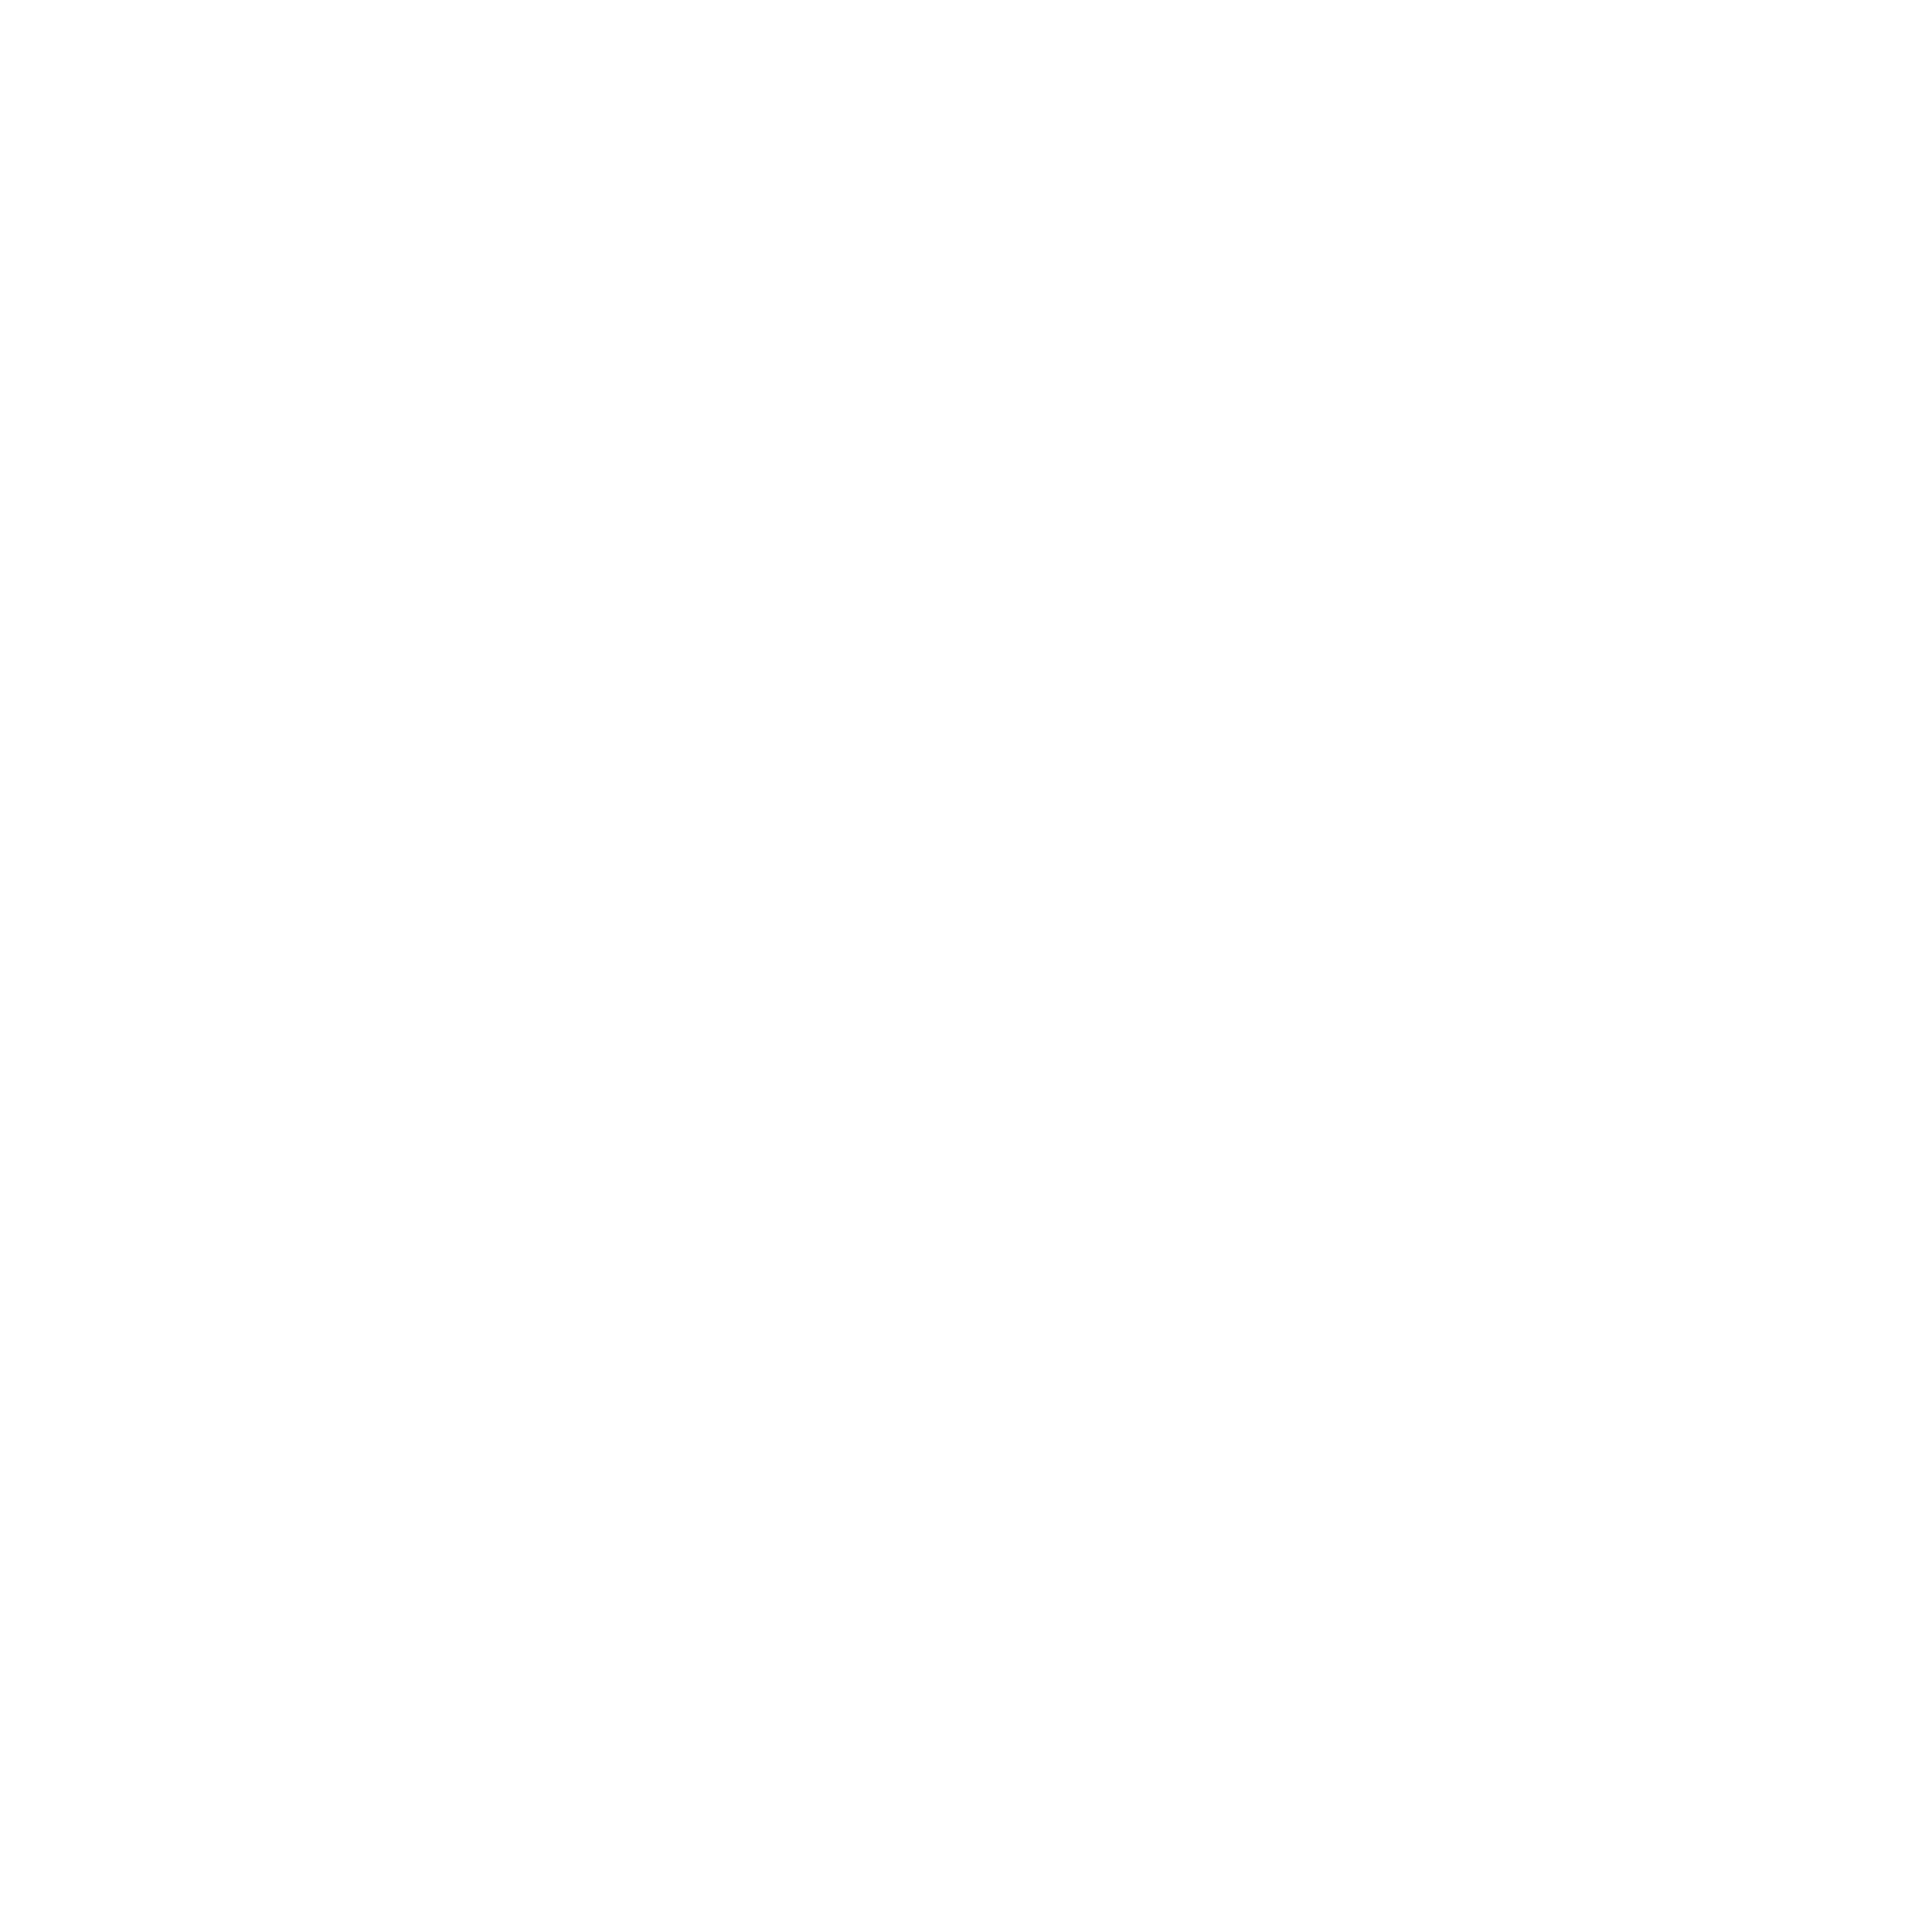

In [1]:
import dgl
from dgl.data import citation_graph as citegrh


data = citegrh.load_cora()
num_classes = 7

import utils
utils.check_intra_prob(data.graph, data.labels, num_classes)

import matplotlib.pyplot as plt
%matplotlib inline
#CORA visualization tool

import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from utils import from_npsp
class LGNNCore(nn.Module):
    def __init__(self, feats, out_feats, radius, mode='g'):
        super(LGNNCore, self).__init__()
        self.mode = mode
        self.out_feats = out_feats
        self.radius = radius
        
        
        self.new_linear = lambda: nn.Linear(feats, out_feats)
        self.new_linear_other = lambda: nn.Linear(out_feats, out_feats)
        
        self.new_linear_list = lambda: nn.ModuleList([self.new_linear() for i in range(radius)])
        self.linear_prev, self.linear_deg = self.new_linear(), self.new_linear()
        self.linear_aggregate = self.new_linear_list()
        
        
        if (mode == 'g'):
            self.linear_fuse = self.new_linear()
        else:
            self.linear_fuse = self.new_linear_other()
        
        
        self.bn = nn.BatchNorm1d(out_feats)
        
    
    def forward(self, g, feat_a, feat_b, deg, pm_pd):
        #feat_a is first parameter in f(a,b), feat_b is second parameter in f(a,b). 
    #degree operator and pm_pd operator are constructed in dataset
        
        def aggregate(g, z):
            z_list = []
            g.ndata['z'] = z
            g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
            z_list.append(g.ndata['z'])
            for i in range(self.radius - 1):
                for j in range(2 ** i):
                    g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
                z_list.append(g.ndata['z'])
            return z_list
        
        def new_aggregate(g, z):
            A = g.adjacency_matrix()
            z_list = []
            exp_adj = z
            exp_adj = th.matmul(A, exp_adj)
            z_list.append(exp_adj)
            for i in range(self.radius - 1):
                for j in range(2 ** i):
                    exp_adj = th.matmul(A, exp_adj)
                z_list.append(exp_adj)
            return z_list
        
        prev_proj = self.linear_prev(feat_a)
        deg_proj = self.linear_deg(deg * feat_a)
        
        twoj_hop = lambda feat : sum(linear(z)
                                     for linear, z in zip(self.linear_aggregate, aggregate(g, feat)))
        
        pmpd_exp = lambda feat : th.matmul(pm_pd, feat)
        
        
        sum_a = twoj_hop(feat_a)
        fuse = self.linear_fuse(pmpd_exp(feat_b))
        
        
        result = prev_proj + deg_proj + sum_a + fuse
        
        n = self.out_feats // 2
        
        result = th.cat([result[:, :n], F.relu(result[:, n:])], 1) #skip connection
        result = self.bn(result)
        
        return result
    
class LGNNLayer(nn.Module):
    def __init__(self, feats, out_feats, radius):
        super(LGNNLayer, self).__init__()
        
        self.g_layer = LGNNCore(feats, out_feats, radius, mode='g')
        self.lg_layer = LGNNCore(feats, out_feats, radius, mode='lg')
    
    def forward(self, g, lg, x, lg_x, deg_g, deg_lg, pm_pd):
        x = self.g_layer(g, x, lg_x, deg_g, pm_pd)
        pm_pd_y = th.transpose(pm_pd, 0, 1)
        lg_x = self.lg_layer(lg, lg_x, x, deg_lg, pm_pd_y) # Here we can add pm_pd_y
        
        return x, lg_x
        
        
    
class LGNN(nn.Module):
    def __init__(self, feats, radius, n_classes):
        """
        Parameters
        ----------
        feats : dimension of intermediate layers
        radius : radius of neighborhood message passing
        n_classes : number of predicted communities, i.e. dimension of last layer
        """
        super(LGNN, self).__init__()
        self.linear = nn.Linear(feats[-1], n_classes)

        self.module_list = nn.ModuleList([LGNNLayer(in_feat, out_feat, radius)
                                          for in_feat, out_feat in zip(
                                              feats[:-1], feats[1:])])
    @from_npsp
    def forward(self, g, lg, deg_g, deg_lg, pm_pd):
        x, lg_x = deg_g, deg_lg
        for module in self.module_list:
            x, lg_x = module(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        return self.linear(x)
    
import time



@from_npsp
def step(i, j, g, lg, deg_g, deg_lg, pmpd, feature, label, equi_label, n_batchsize):
    """ One step of training. """
    t0 = time.time()
    z = model(g, lg, deg_g, deg_lg, pmpd)
    time_forward = time.time() - t0

    #z_list = th.chunk(z, n_batchsize, 0)
    z_list = [z]
    equi_labels = [label, equi_label]
    loss = sum(min(F.cross_entropy(z, y) for y in equi_labels) for z in z_list) / n_batchsize
    
    accu = utils.linegraph_accuracy(z_list, equi_labels)

    optimizer.zero_grad()
    t0 = time.time()
    loss.backward()
    time_backward = time.time() - t0
    optimizer.step()

    return loss, accu, time_forward, time_backward

from dgl.data import binary_sub_graph as bsg
from dgl import DGLGraph
train_set = bsg.CORABinary(DGLGraph(data.graph), data.features, data.labels, num_classes=7)
num_train = len(train_set)
from torch.utils.data import DataLoader
n_batch_size = 2

indices = list(range(num_train))
training_loader = DataLoader(train_set, 
                             n_batch_size,
                             collate_fn=train_set.collate_fn, 
                             drop_last=True)


import torch.optim as optim
n_features = 16
n_layers = 3
radius = 3
lr = 1e-2
K = 2 # num_of_classes
inference_idx = 1
feats = [1] + [n_features]*n_layers + [K]
model = LGNN(feats, radius, K)

optimizer = optim.Adam(model.parameters(), lr=lr)


#main loop



n_iterations = 2
n_epochs = 3
vali_label_change = [] # This is probably not the best practice
total_time = 0
for i in range(n_epochs):
    total_loss, total_accu, s_forward, s_backward = 0, 0, 0, 0
    for j, [g, lg, g_deg, lg_deg, pmpd, subfeature, label, equivariant_label] in enumerate(training_loader):
        loss, accu, t_forward, t_backward = step(i, j, g, lg, g_deg, 
                                                 lg_deg, pmpd, 
                                                 subfeature, label,
                                                 equivariant_label,
                                                 n_batch_size)
        total_loss += loss
        s_forward += t_forward
        s_backward += t_backward
        total_accu += accu
    total_time += (s_forward + s_backward)
    
    print("average loss for epoch {} is {}, with avg accu {}, forward time {}, backward time {}".format(i, total_loss/len(training_loader), total_accu/len(training_loader), s_forward, s_backward))
    [g, lg, g_deg, lg_deg, pmpd, subfeature, label, equi_label] = train_set[inference_idx]    
    z = model(g, lg, g_deg, lg_deg, pmpd)
    vali_label_change.append(th.max(z, 1)[1])
print("total time {} s, average {}".format(total_time, total_time/n_iterations))
vali_label_change.append(equi_label)    
    
    
[g, lg, g_deg, lg_deg, pmpd, subfeature, label, equi_label] = train_set[inference_idx]
utils.linegraph_inference_viz(g, lg, g_deg, lg_deg, pmpd,
                                  subfeature, model)
plt.show()
utils.graph_viz(label, g.to_networkx())
plt.show()


import matplotlib.animation as animation
%matplotlib notebook

[g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equi_label] = train_set[inference_idx]
utils.animate(g, vali_label_change)

In [2]:
import dgl
from dgl.data import citation_graph as citegrh


data = citegrh.load_cora()
num_classes = 7


Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000


In [3]:
import utils
utils.check_intra_prob(data.graph, data.labels, num_classes)

Class 0 : intra connection probability 0.6994106090373281
Class 1 : intra connection probability 0.7949465500485908
Class 2 : intra connection probability 0.9058050383351588
Class 3 : intra connection probability 0.8280479210711769
Class 4 : intra connection probability 0.8291457286432161
Class 5 : intra connection probability 0.7679558011049724
Class 6 : intra connection probability 0.7689969604863222


/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
#CORA visualization tool

In [5]:
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from utils import from_npsp
class LGNNCore(nn.Module):
    def __init__(self, feats, out_feats, radius, mode='g'):
        super(LGNNCore, self).__init__()
        self.mode = mode
        self.out_feats = out_feats
        self.radius = radius
        
        
        self.new_linear = lambda: nn.Linear(feats, out_feats)
        self.new_linear_other = lambda: nn.Linear(out_feats, out_feats)
        
        self.new_linear_list = lambda: nn.ModuleList([self.new_linear() for i in range(radius)])
        self.linear_prev, self.linear_deg = self.new_linear(), self.new_linear()
        self.linear_aggregate = self.new_linear_list()
        
        
        if (mode == 'g'):
            self.linear_fuse = self.new_linear()
        else:
            self.linear_fuse = self.new_linear_other()
        
        
        self.bn = nn.BatchNorm1d(out_feats)
        
    
    def forward(self, g, feat_a, feat_b, deg, pm_pd):
        
        def aggregate(g, z):
            z_list = []
            g.ndata['z'] = z
            g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
            z_list.append(g.ndata['z'])
            for i in range(self.radius - 1):
                for j in range(2 ** i):
                    g.update_all(fn.copy_src(src='z', out='m'), fn.sum(msg='m', out='z'))
                z_list.append(g.ndata['z'])
            return z_list
        
        def new_aggregate(g, z):
            A = g.adjacency_matrix()
            z_list = []
            exp_adj = z
            exp_adj = th.matmul(A, exp_adj)
            z_list.append(exp_adj)
            for i in range(self.radius - 1):
                for j in range(2 ** i):
                    exp_adj = th.matmul(A, exp_adj)
                z_list.append(exp_adj)
            return z_list
        
        prev_proj = self.linear_prev(feat_a)
        deg_proj = self.linear_deg(deg * feat_a)
        
        twoj_hop = lambda feat : sum(linear(z)
                                     for linear, z in zip(self.linear_aggregate, aggregate(g, feat)))
        
        pmpd_exp = lambda feat : th.matmul(pm_pd, feat)
        
        
        sum_a = twoj_hop(feat_a)
        fuse = self.linear_fuse(pmpd_exp(feat_b))
        
        
        result = prev_proj + deg_proj + sum_a + fuse
        
        n = self.out_feats // 2
        
        result = th.cat([result[:, :n], F.relu(result[:, n:])], 1) #skip connection
        result = self.bn(result)
        
        return result
    
class LGNNLayer(nn.Module):
    def __init__(self, feats, out_feats, radius):
        super(LGNNLayer, self).__init__()
        
        self.g_layer = LGNNCore(feats, out_feats, radius, mode='g')
        self.lg_layer = LGNNCore(feats, out_feats, radius, mode='lg')
    
    def forward(self, g, lg, x, lg_x, deg_g, deg_lg, pm_pd):
        x = self.g_layer(g, x, lg_x, deg_g, pm_pd)
        pm_pd_y = th.transpose(pm_pd, 0, 1)
        lg_x = self.lg_layer(lg, lg_x, x, deg_lg, pm_pd_y) # Here we can add pm_pd_y
        
        return x, lg_x
        
        
    
class LGNN(nn.Module):
    def __init__(self, feats, radius, n_classes):
        """
        Parameters
        ----------
        feats : dimension of intermediate layers
        radius : radius of neighborhood message passing
        n_classes : number of predicted communities, i.e. dimension of last layer
        """
        super(LGNN, self).__init__()
        self.linear = nn.Linear(feats[-1], n_classes)

        self.module_list = nn.ModuleList([LGNNLayer(in_feat, out_feat, radius)
                                          for in_feat, out_feat in zip(
                                              feats[:-1], feats[1:])])
    @from_npsp
    def forward(self, g, lg, deg_g, deg_lg, pm_pd):
        x, lg_x = deg_g, deg_lg
        for module in self.module_list:
            x, lg_x = module(g, lg, x, lg_x, deg_g, deg_lg, pm_pd)
        return self.linear(x)

In [6]:
import time



@from_npsp
def step(i, j, g, lg, deg_g, deg_lg, pmpd, feature, label, equi_label, n_batchsize):
    """ One step of training. """
    t0 = time.time()
    z = model(g, lg, deg_g, deg_lg, pmpd)
    time_forward = time.time() - t0

    #z_list = th.chunk(z, n_batchsize, 0)
    z_list = [z]
    equi_labels = [label, equi_label]
    loss = sum(min(F.cross_entropy(z, y) for y in equi_labels) for z in z_list) / n_batchsize
    
    accu = utils.linegraph_accuracy(z_list, equi_labels)

    optimizer.zero_grad()
    t0 = time.time()
    loss.backward()
    time_backward = time.time() - t0
    optimizer.step()

    return loss, accu, time_forward, time_backward

In [7]:
from dgl.data import binary_sub_graph as bsg
from dgl import DGLGraph
train_set = bsg.CORABinary(DGLGraph(data.graph), data.features, data.labels, num_classes=7)
num_train = len(train_set)
from torch.utils.data import DataLoader
n_batch_size = 2

indices = list(range(num_train))
training_loader = DataLoader(train_set, 
                             n_batch_size,
                             collate_fn=train_set.collate_fn, 
                             drop_last=True)

/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


In [8]:
import torch.optim as optim
n_features = 16
n_layers = 3
radius = 3
lr = 1e-2
K = 2 # num_of_classes
inference_idx = 1
feats = [1] + [n_features]*n_layers + [K]
model = LGNN(feats, radius, K)

optimizer = optim.Adam(model.parameters(), lr=lr)

average loss for epoch 0 is 0.33915334939956665, with avg accu 0.615178708312974, forward time 1.8863139152526855, backward time 0.9826610088348389
average loss for epoch 1 is 0.3293324410915375, with avg accu 0.6180414170855201, forward time 1.8632733821868896, backward time 1.163529634475708
average loss for epoch 2 is 0.3137395977973938, with avg accu 0.6242461921795088, forward time 1.9712913036346436, backward time 1.0741550922393799
total time 8.941224336624146 s, average 4.470612168312073


/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


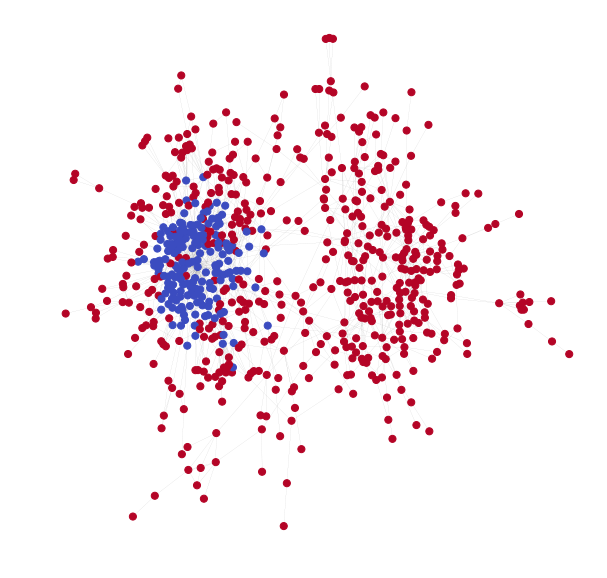

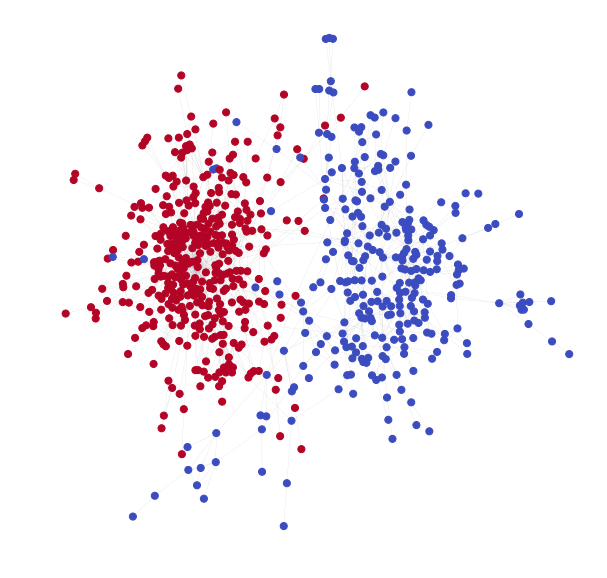

In [9]:
#main loop



n_iterations = 2
n_epochs = 3
vali_label_change = [] # This is probably not the best practice
total_time = 0
for i in range(n_epochs):
    total_loss, total_accu, s_forward, s_backward = 0, 0, 0, 0
    for j, [g, lg, g_deg, lg_deg, pmpd, subfeature, label, equivariant_label] in enumerate(training_loader):
        loss, accu, t_forward, t_backward = step(i, j, g, lg, g_deg, 
                                                 lg_deg, pmpd, 
                                                 subfeature, label,
                                                 equivariant_label,
                                                 n_batch_size)
        total_loss += loss
        s_forward += t_forward
        s_backward += t_backward
        total_accu += accu
    total_time += (s_forward + s_backward)
    
    print("average loss for epoch {} is {}, with avg accu {}, forward time {}, backward time {}".format(i, total_loss/len(training_loader), total_accu/len(training_loader), s_forward, s_backward))
    [g, lg, g_deg, lg_deg, pmpd, subfeature, label, equi_label] = train_set[inference_idx]    
    z = model(g, lg, g_deg, lg_deg, pmpd)
    vali_label_change.append(th.max(z, 1)[1])
print("total time {} s, average {}".format(total_time, total_time/n_iterations))
vali_label_change.append(equi_label)    
    
    
[g, lg, g_deg, lg_deg, pmpd, subfeature, label, equi_label] = train_set[inference_idx]
utils.linegraph_inference_viz(g, lg, g_deg, lg_deg, pmpd,
                                  subfeature, model)
plt.show()
utils.graph_viz(label, g.to_networkx())
plt.show()

In [10]:
import matplotlib.animation as animation
%matplotlib notebook

<IPython.core.display.Javascript object>


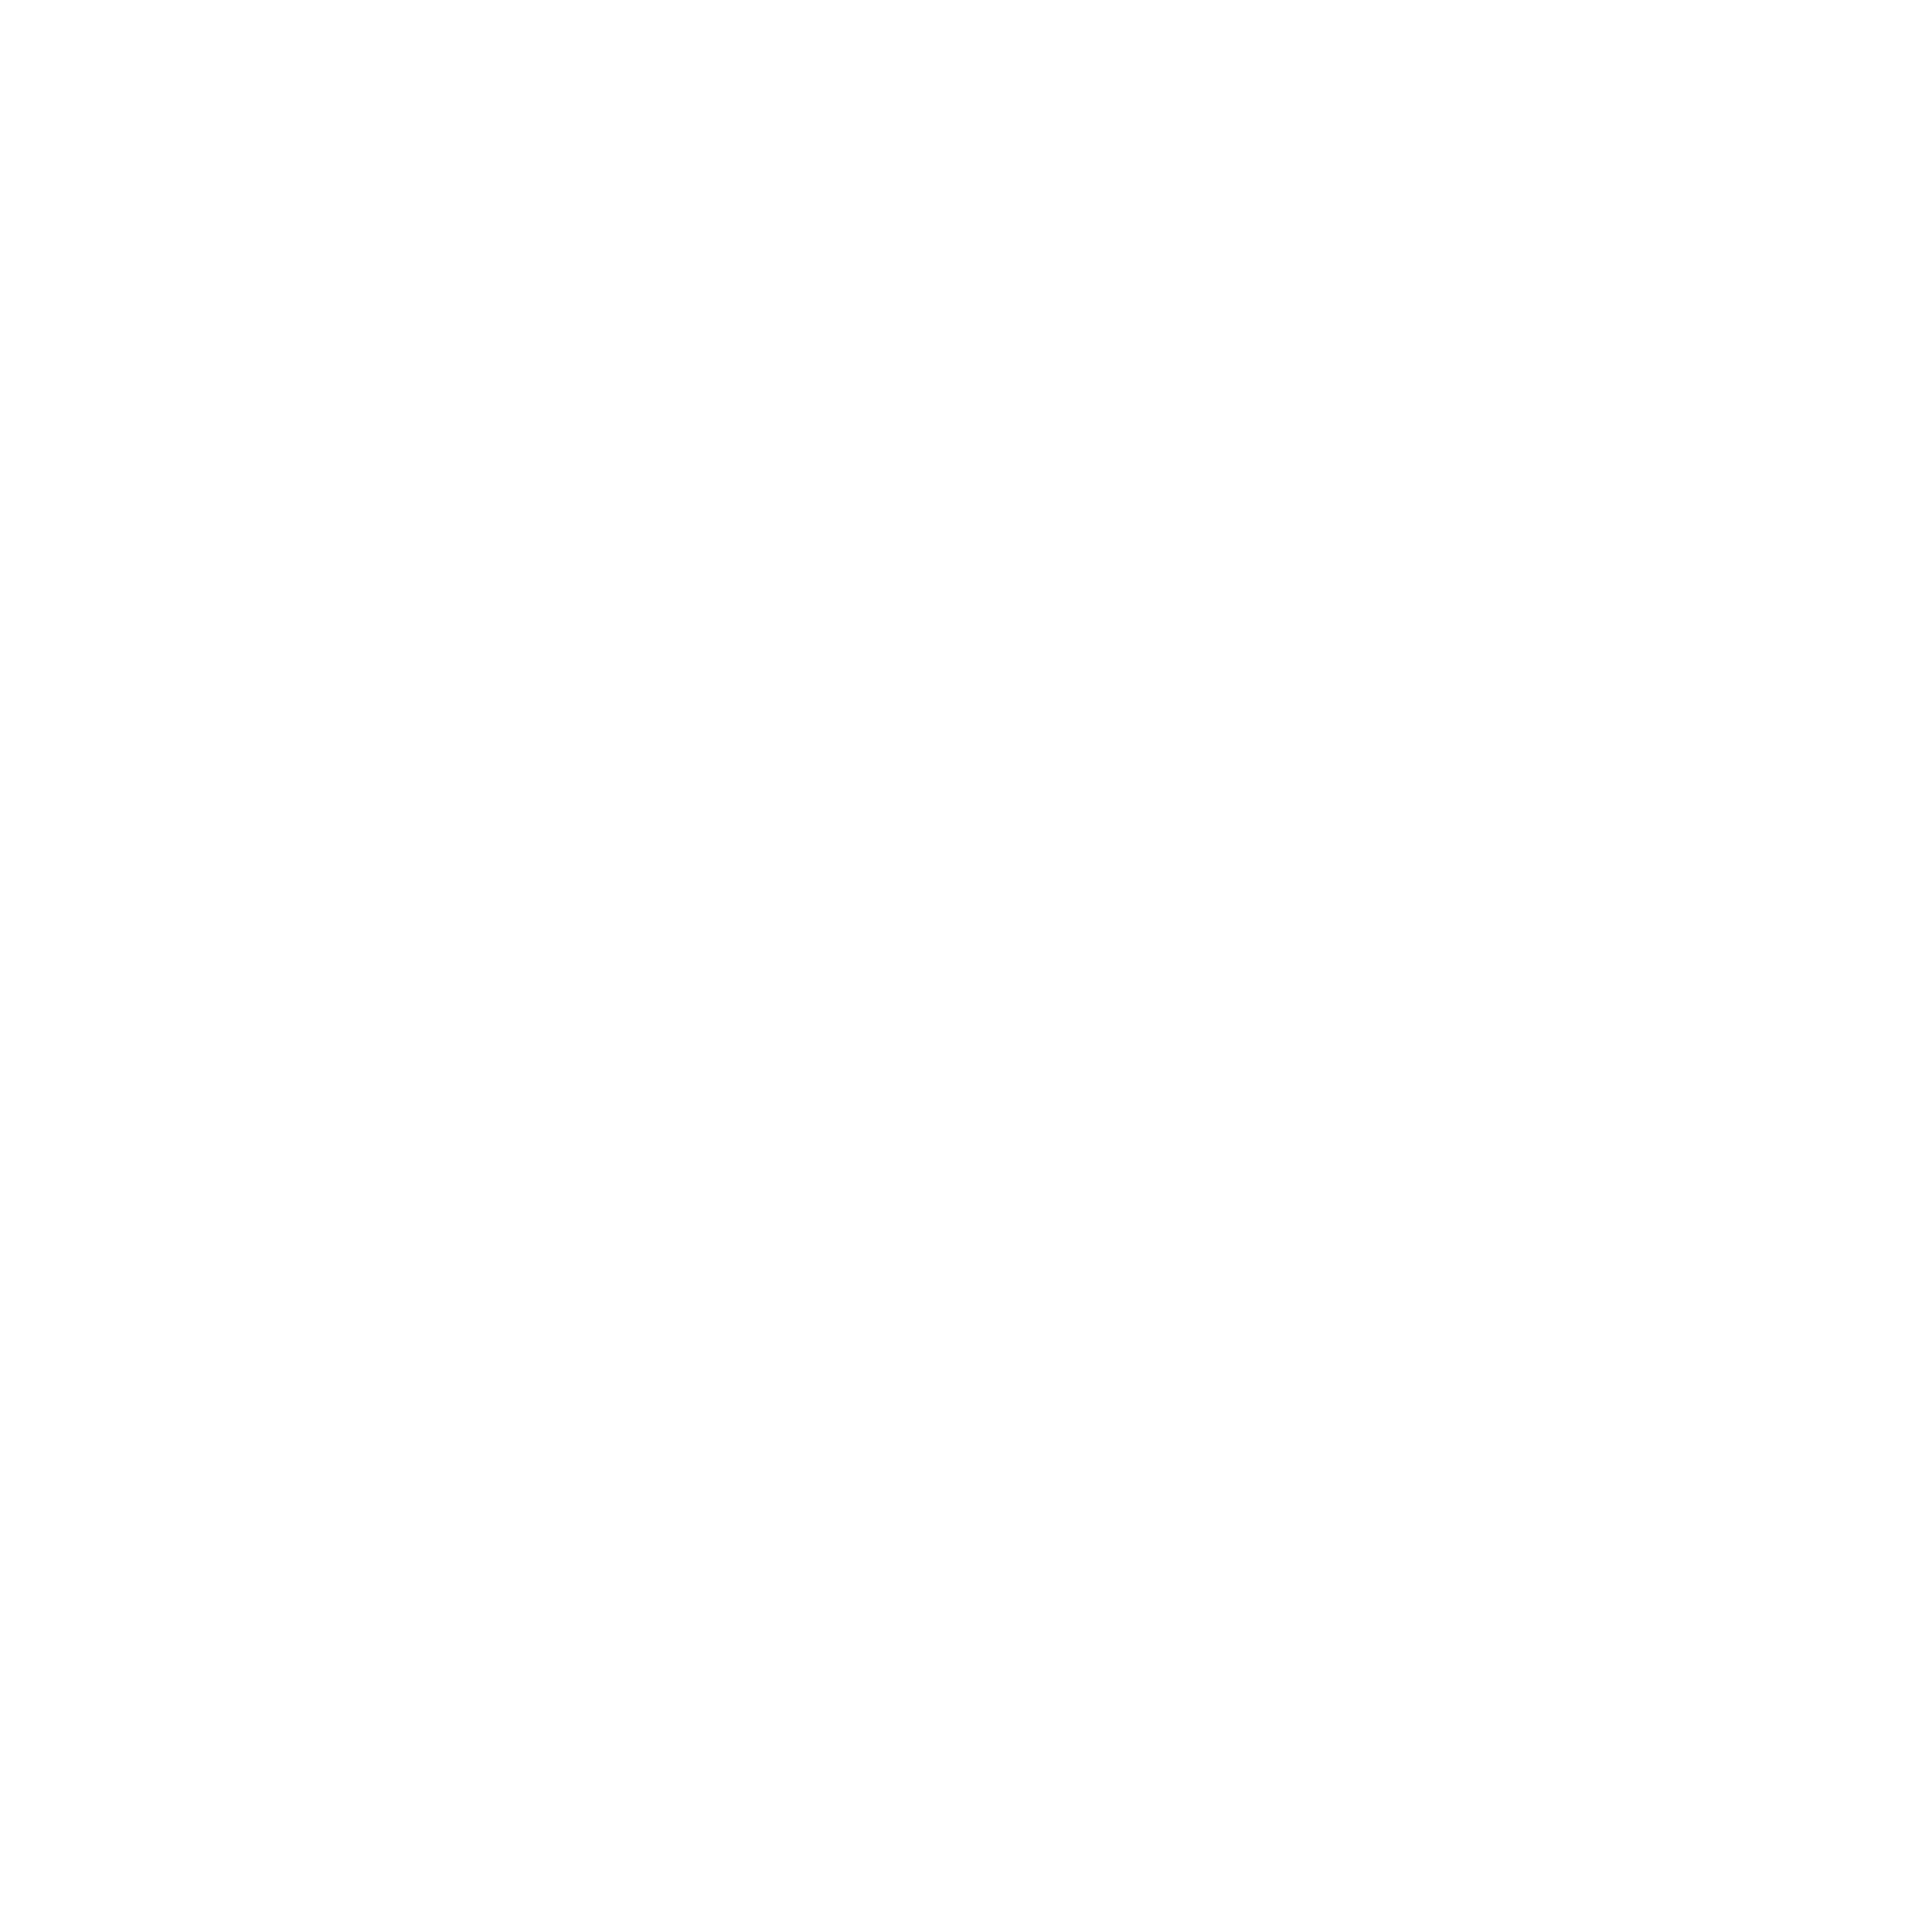

/data/huangqi/dgl2/dgl/python/dgl/graph.py:657: UserWarning: to_networkx currently does not support converting node/edge features automatically.
  dgl_warning('to_networkx currently does not support converting'


<IPython.core.display.Javascript object>


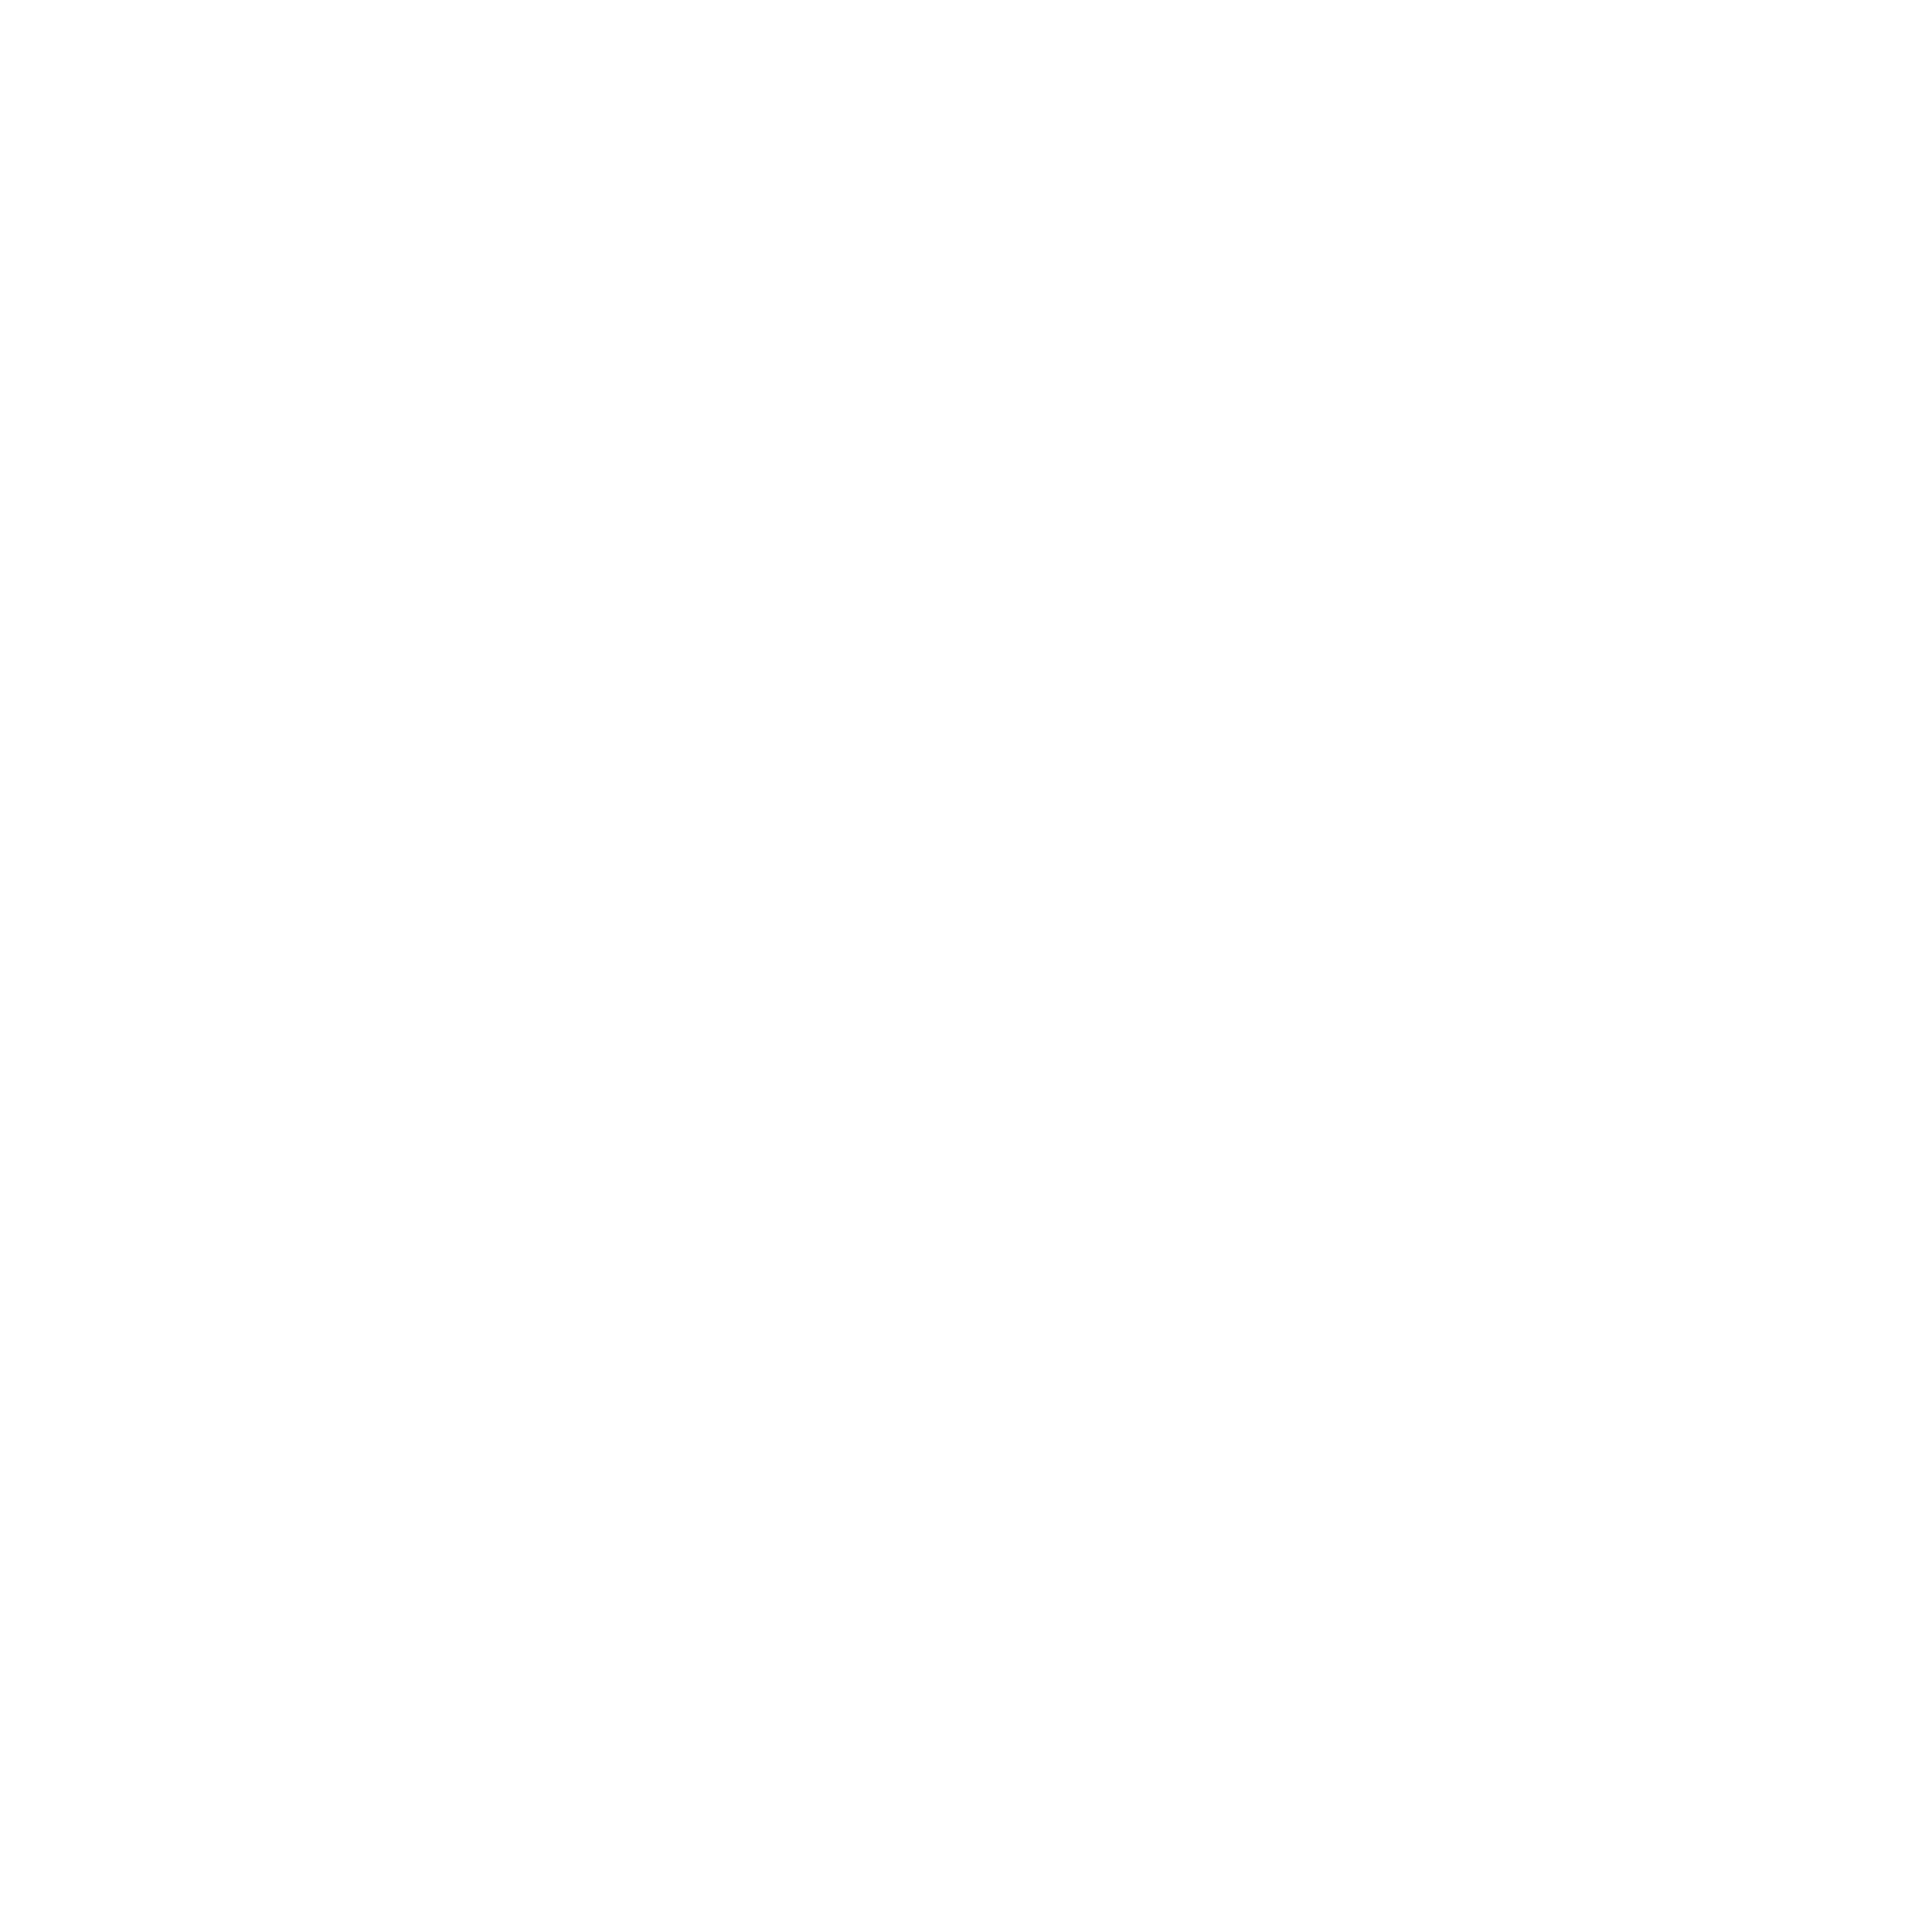

In [11]:
[g, lg, g_deg, lg_deg, pm_pd, subfeature, label, equi_label] = train_set[inference_idx]
utils.animate(g, vali_label_change)